<center>

# dask-image: distributed image processing for large data

## Presenter: Genevieve Buckley

<img src="imgs/dask-icon.svg#thumbnail" alt="dask logo" width="100"/>
</center>


# Who needs dask-image?

If you're using `numpy` and/or `scipy.ndimage` and are running out of RAM, dask-image is for you.

## Two main use cases
1. Batch processing
2. Large field of view

# Motivating examples

* Sentinel satellite data
* Individual neurons within the brain

<img src="imgs/motivating-examples.png#thumbnail" alt="Satellite data and brain neurons" width="1000"/>


# Getting started
https://github.com/dask/dask-image/

## conda
```
conda install -c conda-forge dask-image
```

## pip

```
pip install dask-image
```


# What's included?

* imread
* ndfilters
* ndfourier
* ndmorph
* ndmeasure



# Function coverage

<img src="imgs/function-coverage-table.png#thumbnail" alt="Table of function coverage: scipy.ndimage compared to dask-image http://image.dask.org/en/latest/coverage.html" width="900"/>


# GPU support

Latest release includes GPU support for the modules:
* ndfilters
* imread

Still to do: ndfourier, ndmeasure, ndmorph*

*Done, pending cupy PR #3907

# GPU benchmarking

| Architecture    | Time      |
|-----------------|-----------|
| Single CPU Core | 2hr 39min |
| Forty CPU Cores | 11min 30s |
| One GPU         | 1min 37s  |
| Eight GPUs      | 19s       |

https://blog.dask.org/2019/01/03/dask-array-gpus-first-steps


# Let's build a pipeline!

1. Reading in data
2. Filtering images
3. Segmenting objects
4. Morphological operations
5. Measuring objects

In [1]:
%gui qt

We used image set [BBBC039v1](https://bbbc.broadinstitute.org/bbbc/BBBC039) Caicedo et al. 2018, available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083). 

https://bbbc.broadinstitute.org/BBBC039

<img src="imgs/BBBC039-example-image.png#thumbnail" alt="BBBC039 image of flourescent nuclei" width="700"/>


# 1. Reading in data


In [2]:
from dask_image.imread import imread

images = imread('data/BBBC039/images/*.tif')
# images_on_gpu = imread('data/BBBC039/images/*.tif', arraytype="cupy")

images


,Array,Chunk
Bytes,144.77 MB,723.84 kB
Shape,"(200, 520, 696)","(1, 520, 696)"
Count,600 Tasks,200 Chunks
Type,uint16,numpy.ndarray


# 2. Filtering images
Denoising images with a small blur can improve segmentation later on.

In [3]:
from dask_image import ndfilters

smoothed = ndfilters.gaussian_filter(images, sigma=[0, 1, 1]) 


# 3. Segmenting objects
Pixels below the threshold value are background.

In [4]:
absolute_threshold = smoothed > 160

In [5]:
# Let's have a look at the images
import napari

viewer = napari.Viewer() 
viewer.add_image(absolute_threshold)
viewer.add_image(images, contrast_limits=[0, 2000])

<Image layer 'images' at 0x7fb2ec13a910>

# 3. Segmenting objects (continued)

A better segmentation using local thresholding.


In [6]:
thresh = ndfilters.threshold_local(smoothed, images.chunksize)
threshold_images = smoothed > thresh

In [7]:
# Let's take a look at the images
viewer.add_image(threshold_images)

<Image layer 'threshold_images' at 0x7fb2ede7b090>

# 4. Morphological operations

These are operations on the shape of a binary image.

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html



## Erosion

<img src="imgs/erosion.png#thumbnail" alt="Erosion, binary morphological operation 
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
" width="500"/>

## Dilation

<img src="imgs/dilation.png#thumbnail" alt="Dilation, binary morphological operation 
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
" width="500"/>


A morphological opening operation is an erosion, followed by a dilation.

<img src="imgs/opening.png#thumbnail" alt="Opening, binary morphological operation 
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
" width="500"/>


In [8]:
from dask_image import ndmorph
import numpy as np

structuring_element = np.array([
    [[0, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 1, 0], [1, 1, 1], [0, 1, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, 0]]])
binary_images = ndmorph.binary_opening(threshold_images, structure=structuring_element) 


# 5. Measuring objects
Each image has many individual nuclei, so for the sake of time we'll measure a small subset of the data.

In [9]:
from dask_image import ndmeasure

# Create labelled mask
label_images, num_features = ndmeasure.label(binary_images[:3], structuring_element)
index = np.arange(num_features - 1) + 1  # [1, 2, 3, ...num_features]
print("Number of nuclei:", num_features.compute())


Number of nuclei: 271


In [10]:
# Let's look at the labels
viewer.add_labels(label_images)
viewer.dims.set_point(0, 0)

# Measuring objects (continued)

In [11]:
# Measure objects in images
area = ndmeasure.area(images[:3], label_images, index)
mean_intensity = ndmeasure.mean(images[:3], label_images, index)  

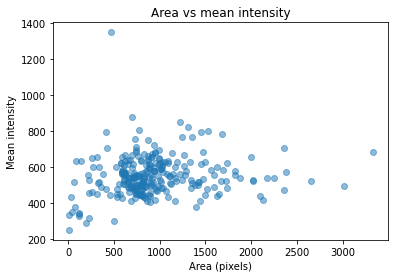

In [12]:
# Run computation and plot results
import matplotlib.pyplot as plt

plt.scatter(area, mean_intensity, alpha=0.5)
plt.gca().update(dict(title="Area vs mean intensity", xlabel='Area (pixels)', ylabel='Mean intensity'))
plt.show()


# The full pipeline

```python
import numpy as np
from dask_image.imread import imread
from dask_image import ndfilters, ndmorph, ndmeasure

images = imread('data/BBBC039/images/*.tif')
smoothed = ndfilters.gaussian_filter(images, sigma=[0, 1, 1])
thresh = ndfilters.threshold_local(smoothed, blocksize=images.chunksize)
threshold_images = smoothed > thresh
structuring_element = np.array([[[0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 1, 0], [1, 1, 1], [0, 1, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0]]])
binary_images = ndmorph.binary_closing(threshold_image, structure=structuring_element)
label_images, num_features = ndmeasure.label(binary_image)
index = np.arange(num_features)
area = ndmeasure.area(images, label_images, index)
mean_intensity = ndmeasure.mean(images, label_images, index)
```

# Custom functions

What if you want to do something that isn't included?

* scikit-image [apply_parallel()](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.apply_parallel)
* dask [map_overlap](https://docs.dask.org/en/latest/array-overlap.html?highlight=map_overlap#dask.array.map_overlap) / [map_blocks](https://docs.dask.org/en/latest/array-api.html?highlight=map_blocks#dask.array.map_blocks)
* dask [delayed](https://docs.dask.org/en/latest/delayed.html) 

# Scaling up computation

Use [dask-distributed](https://distributed.dask.org/en/latest/) to scale up from a laptop onto a supercomputing cluster.

```python
from dask.distributed import Client

# Setup a local cluster
# By default this sets up 1 worker per core
client = Client()
client.cluster

```

# dask-image

* Install: `conda` or `pip install dask-image`
* Documentation: https://dask-image.readthedocs.io
* GitHub: https://github.com/dask/dask-image/

<center>
<img src="imgs/dask-icon.svg#thumbnail" alt="dask logo" width="300"/>
</center>
 

# Bonus content
## Example using arrays on GPU

```python
# CPU example
import numpy as np
import dask.array as da
from dask_image.ndfilters import convolve

s = (10, 10)
a = da.from_array(np.arange(int(np.prod(s))).reshape(s), chunks=5)
w = np.ones(a.ndim * (3,), dtype=np.float32)
result = convolve(a, w)
result.compute()
```

```python
# Same example moved to the GPU
import cupy  # <- import cupy instead of numpy (version >=7.7.0)
import dask.array as da
from dask_image.ndfilters import convolve

s = (10, 10)
a = da.from_array(cupy.arange(int(cupy.prod(cupy.array(s)))).reshape(s), chunks=5)  # <- cupy dask array
w = cupy.ones(a.ndim * (3,))  # <- cupy dask array
result = convolve(a, w)
result.compute()
```